# Load Necessary Libraries

In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, csv
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import warnings

# Data Acquistion

## Obtain Respiratory Disease Mortality Rate Data
I obtained yearly data on mortality rate and causes from the CDC website. The data is on the county level, so I will be looking at Montgomery County (the county Daytion, Ohio is located in). I had to download the data in three separate .txt files where the data in each file was tab separated. I read in each file separately and concatenated them row wise and dropped any unnecessary columns. My final dataset consisted of the following columns: year, number of deaths by respiratory diseases per 100,000 people (crude rate), population, and deaths. I use the crude rate columns for all my calculations as it gives a better representation per capita of the effect of deaths by respiratory diseases in a given year. 

CDC data source citation: Centers for Disease Control and Prevention. CDC WONDER. U.S. Department of Health and Human Services, 2024,
https://wonder.cdc.gov/cmf-icd8.html. 

In [10]:
# read in tab separated .txt files and filter rows with data descriptions 
df1 = pd.read_csv('../resp_78.txt', delimiter='\t', quotechar='"')[:11]
df2 = pd.read_csv('../resp_98.txt', delimiter='\t', quotechar='"')[:20]
df3 = pd.read_csv('../resp_16.txt', delimiter='\t', quotechar='"')[:18]

# concat data frames row wise and drop unnecessary columns 
final = pd.concat([df1, df2, df3]).drop(columns = ['Notes', 'Year Code'])
final.head()

,Year,Deaths,Population,Crude Rate
0,1968.0,301.0,616097.0,48.9
1,1969.0,281.0,611701.0,45.9
2,1970.0,287.0,609489.0,47.1
3,1971.0,241.0,604330.0,39.9
4,1972.0,256.0,600878.0,42.6


## Obtain Smoke Estimate Data
I saved my smoke estimate data from Part 1: Common Analysis into a csv file that I just read in for this analysis. For the fires within 650 miles of Dayton, Ohio, I calculated the smoke estimate using the following equation: *GIS_Acres / (distance)^2*. I calculated the smoke estimate for each fire within a 650 mile radius of Dayton, Ohio and then added the estimates for a given year to get each year's final smoke estimate. Thus, my final dataframe is the year and its corresponding smoke estimate. 

In [11]:
# read in smoke estimate data that was saved during part 1
est = pd.read_csv('estimate.csv')
est.head()

,Year,Estimate
0,1962,0.000413
1,1963,0.000217
2,1965,0.000082
3,1966,0.000003
4,1967,0.000128


## Combine Smoke Estimate Data and Respiratory Disease Mortality Rate Data
The respiratory disease mortality rate data from the CDC only contains data from years 1968 - 2016. The smoke estimate data ranges from 1962 - 2021. I imputed the crude rate column for the respiratory disease data using a 5 year moving average so that both datasets had the same range of years available, making them easier to merge. I merged both dataframes on year. I also removed an outlier from my smoke estimate data so that it would not skew the predictions. 

In [12]:
# create dataframe with full range of years 
full_year_range = pd.DataFrame({'Year': range(1962, 2021)})

# merge with respiratory disease data, filling the years from 1962-1967 and 2017-2020 with NaN
df_full = full_year_range.merge(final, on='Year', how='left')

df_imputed = df_full.copy()  

# apply rolling window to impute missing values (using a 5-year moving average) for CrudeRate column
df_imputed['Crude Rate'] = df_imputed['Crude Rate'].fillna(df_imputed['Crude Rate'].rolling(window=5, min_periods=1, center=True).mean())
df_imputed['Crude Rate'] = df_imputed['Crude Rate'].rolling(window=5, min_periods=1, center=True).mean()
df_imputed['Crude Rate'] = df_imputed['Crude Rate'].rolling(window=5, min_periods=1, center=True).mean()

# merge on year and select relevant columns
df = pd.merge(df_imputed, est, on = 'Year')[['Year', 'Crude Rate', 'Estimate']]

# remove outlier 
df = df.drop(27)
df.head()


,Year,Crude Rate,Estimate
0,1962,48.90000,0.000413
1,1963,48.52500,0.000217
2,1965,48.30625,0.000082
3,1966,48.17300,0.000003
4,1967,47.56100,0.000128


# Data Visualization and Analysis

To visualize my two datasets (respiratory disease death rate and smoke estimate), I first used a simple time series plot to compare the yearly trend between the two. I scaled both datasets (using min max scaling) as I am more interested in trends between smoke estimate and respiratory disease death rate than their actual values. Scaling allows us to see both on the same graph and how the trends between the two compare. 

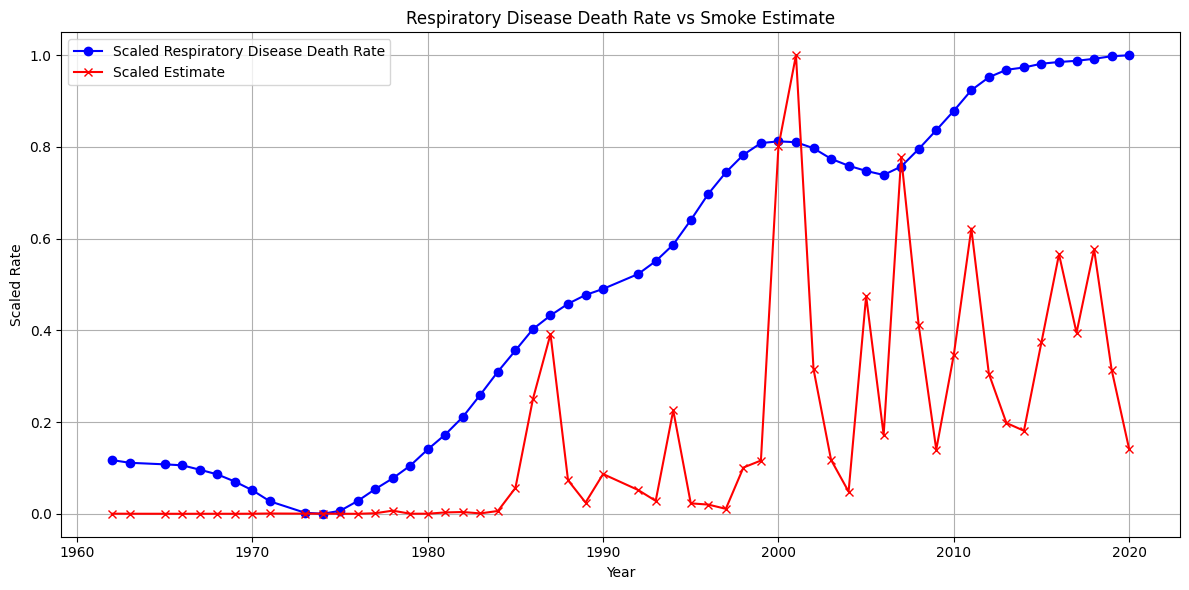

In [13]:
# define scaler object
scaler = MinMaxScaler()

# scale both respiratory disease mortality rate and smoke estimate
df[['ScaledCrudeRate', 'ScaledEstimate']] = scaler.fit_transform(df[['Crude Rate', 'Estimate']])

plt.figure(figsize=(12, 6))

plt.plot(df['Year'], df['ScaledCrudeRate'], label='Scaled Respiratory Disease Death Rate', color='blue', marker='o')
plt.plot(df['Year'], df['ScaledEstimate'], label='Scaled Estimate ', color='red', marker='x')
plt.title('Respiratory Disease Death Rate vs Smoke Estimate')
plt.xlabel('Year')
plt.ylabel('Scaled Rate')
plt.legend()

# show plots
plt.grid()
plt.tight_layout()
plt.show()

I also forecasted the time series above using an ARIMA model to see what the trend looks like between the smoke estimate and mortality rate and whether they are comparable. I used an ARIMA model to forecast both time series. To meet the stationarity assumption for an ARIMA model I used the Augmented Dickey-Fuller test (shown below). The p value for both the smoke estimate and the mortality rate was below 0.05 confirming that data is stationary and can approprately be used in an ARIMA model. 

In [14]:
def calc_ad_fuller():
    # apply Augmented Dickey-Fuller test for smoke estimate data 
    result = adfuller(df['ScaledEstimate'])
    print('Smoke Estimate ADF Statistic:', result[0])
    print('Smoke Estimate p-value:', result[1])

    # apply Augmented Dickey-Fuller test for respiratory disease data
    result = adfuller(df_imputed['Crude Rate'])
    print('Respiratory Disease Mortalty Rate ADF Statistic:', result[0])
    print('Respiratory Diseas Mortality Rate p-value:', result[1])

calc_ad_fuller()

Smoke Estimate ADF Statistic: -3.756683208145581
Smoke Estimate p-value: 0.0033829297425266016
Respiratory Disease Mortalty Rate ADF Statistic: -1.9298008472208574
Respiratory Diseas Mortality Rate p-value: 0.31817429818798804


The respiratory disease mortality rate forecast is alot more constant than the smoke estimate forecast. The respiratory disease mortality rate forecast also stays relatively high, indicating that it remains a consistent issue throughout the next 20 years. While the smoke estimate forecast is more noisy, it also tapers off around 2035. We also have to keep in mind that the last 5 years (2017- 2021) of my respiratory disease data is imputed, so the forecast is not necessarily 100% accurate. 

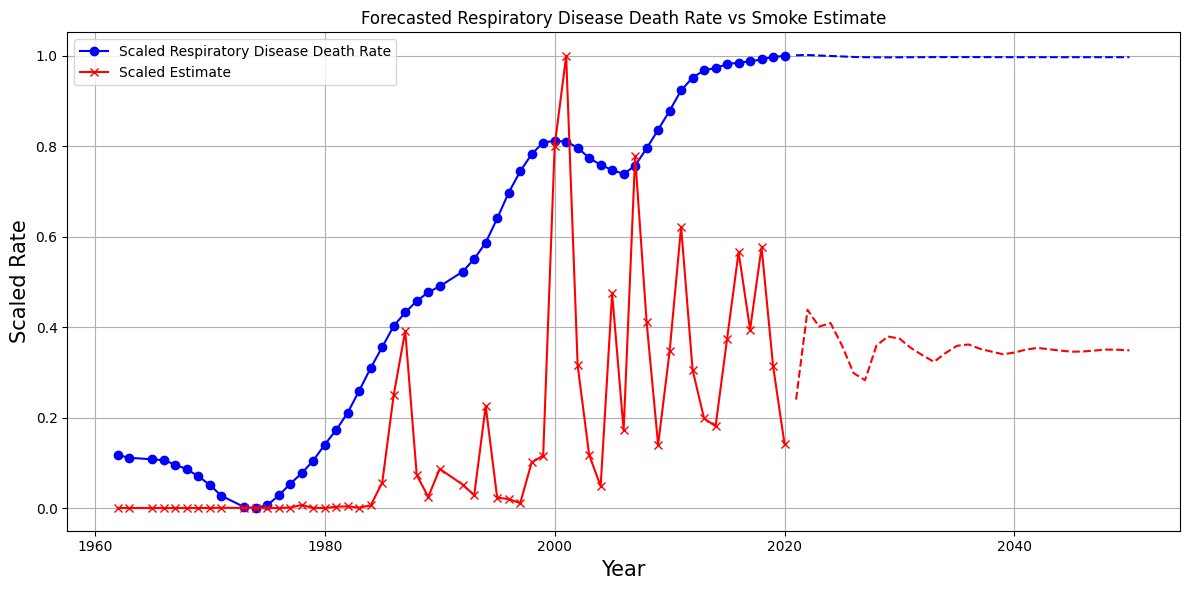

In [15]:
warnings.simplefilter(action='ignore')

# fit ARIMA model to respiratory disease data 
model_crude = ARIMA(df['ScaledCrudeRate'], order=(5, 1, 0))  
model_crude_fit = model_crude.fit()

# fit ARIMA model for smoke estimate 
model_death = ARIMA(df['ScaledEstimate'], order=(5, 1, 0))  # (p, d, q) order
model_death_fit = model_death.fit()

# forecast the next 30 years (1968 - 2020 is the historical period, 2021-2050 is the forecast period)
forecast_years = 30
forecast_crude = model_crude_fit.forecast(steps=forecast_years)
forecast_death = model_death_fit.forecast(steps=forecast_years)

# create new years for the forecast period
forecast_years_range = list(range(2021, 2021 + forecast_years))

# create data frame for the forecasted data
forecast_df = pd.DataFrame({
    'Year': forecast_years_range,
    'ForecastedCrudeRate': forecast_crude,
    'ForecastedDeathRate': forecast_death
})

# plot original and forecasted data 
plt.figure(figsize=(12, 6))

plt.plot(df['Year'], df['ScaledCrudeRate'], label='Scaled Respiratory Disease Death Rate', color='blue', marker='o')
plt.plot(forecast_df['Year'], forecast_df['ForecastedCrudeRate'], color='blue', linestyle='--')
plt.title('Forecasted ScaledCrudeRate for the Next 30 Years')

plt.plot(df['Year'], df['ScaledEstimate'], label='Scaled Estimate', color='red', marker='x')
plt.plot(forecast_df['Year'], forecast_df['ForecastedDeathRate'], color='red', linestyle='--')
plt.title('Forecasted Respiratory Disease Death Rate vs Smoke Estimate')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Scaled Rate', fontsize = 15)
plt.legend()

# show plots
plt.tight_layout()
plt.grid()

plt.show()


## Correlation Analysis
I also looked at the correlation between my smoke estimate and the respiratory disease rate. The Pearson correlation coefficient of 0.64 suggests that as smoke estimates go up, the respiratory disease mortality rate tends to increase as well, pointing to a likely connection between the two. While this is a pretty strong positive relationship, it also means that smoke estimate could be a big factor, though other things might be affecting the disease rate too. To get a clearer picture, we'd need to dig deeper, maybe looking at how smoking impacts the disease rate over time or checking for other factors. Still, it highlights how important it is to focus on smoking when thinking about ways to lower respiratory disease deaths.

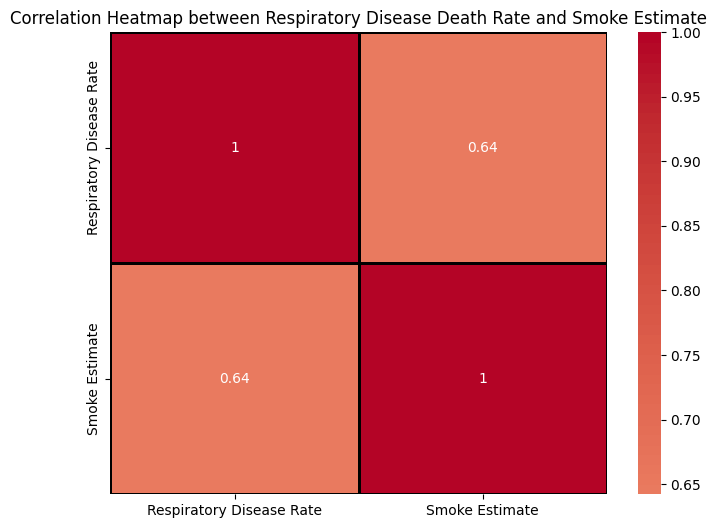

In [16]:
def plot_corr():
    df_plt = df.rename(columns = {'ScaledCrudeRate': 'Respiratory Disease Rate',
                            'ScaledEstimate': 'Smoke Estimate'})

    # calculate Pearson correlation 
    correlation_matrix = df_plt[['Respiratory Disease Rate', 'Smoke Estimate']].corr()

    # create heatmap and plot correlation matrix 
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1, linecolor='black')

    # show plot 
    plt.title('Correlation Heatmap between Respiratory Disease Death Rate and Smoke Estimate')
    plt.show()

plot_corr()

## Apply Time Series Functions and ARIMAX Time Series Model 
I chose to use the ARIMAX model to forecast the respiratory disease mortality rate using smoke estimate as the exogenous variable. This allows me to use the past respiratory disease rate values and the smoke estimate as the predictors to make accurate predictions on future respiratory disease rates (response). The ARIMAX model build on top of the traditional ARIMA model by incorporating my smoke estimate as an external variable.

I also looked at the Autocorrelation and Partial Autocorrelation Functions for the smoke estimate and health data. The ACF helps reveal dependencies and correlation in the time series, such as how strongly past values of a variable influence the current value. For example, if smoke estimate values tend to stay relatively consistent over time, the ACF might show a high correlation with past values (indicating persistence in smoke estimate patterns). For the respiratory disease rate, the ACF of the disease rate will reveal how current mortality rates are related to their past values (lags). If there is seasonality (periodic fluctuations), the ACF can help identify them, such as a correlation between current rates and those from one year ago.  

The PACF shows the direct correlation between the smoke estimate and its past values, without the influence of the values in between. If a specific past value is significant in the PACF, it indicates that this particular past value has a unique impact on the current smoking estimate, independent of earlier values.
The PACF of the respiratory disease death rate will show how past disease rates directly affect the current rate. If certain past time points show significant correlations in the PACF, it suggests that these specific moments in the past have a direct effect on future mortality rates.

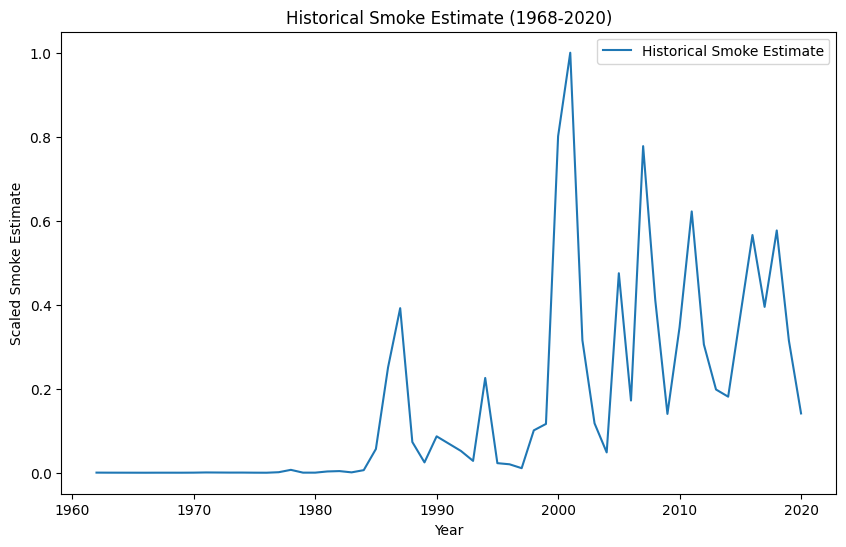

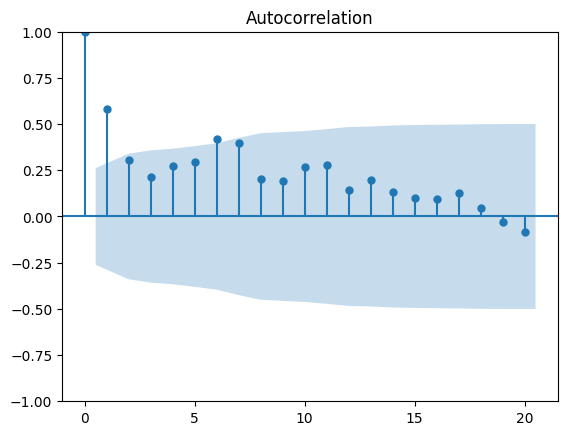

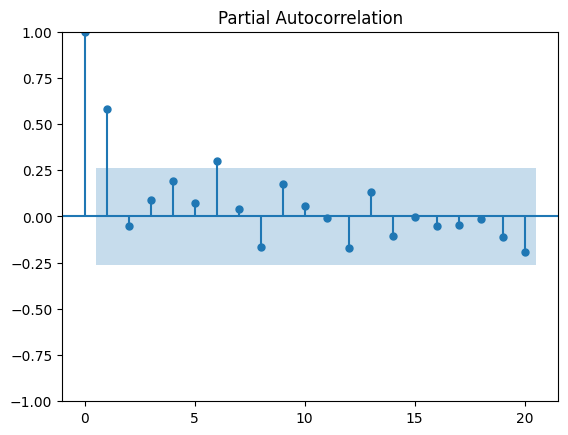

In [17]:
def plot_est_acf_pacf():
    # create copy to avoid in place modifications 
    df_copy = df.copy()
    df_copy.set_index('Year', inplace=False)  

    # show plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_copy['Year'], df_copy['ScaledEstimate'], label='Historical Smoke Estimate')
    plt.title('Historical Smoke Estimate (1968-2020)')
    plt.xlabel('Year')
    plt.ylabel('Scaled Smoke Estimate')
    plt.legend()
    plt.show()

    # check ACF and PACF plots to determine ARIMA order
    plot_acf(df_copy['ScaledEstimate'], lags=20)
    plot_pacf(df_copy['ScaledEstimate'], lags=20)
    plt.show()

plot_est_acf_pacf()


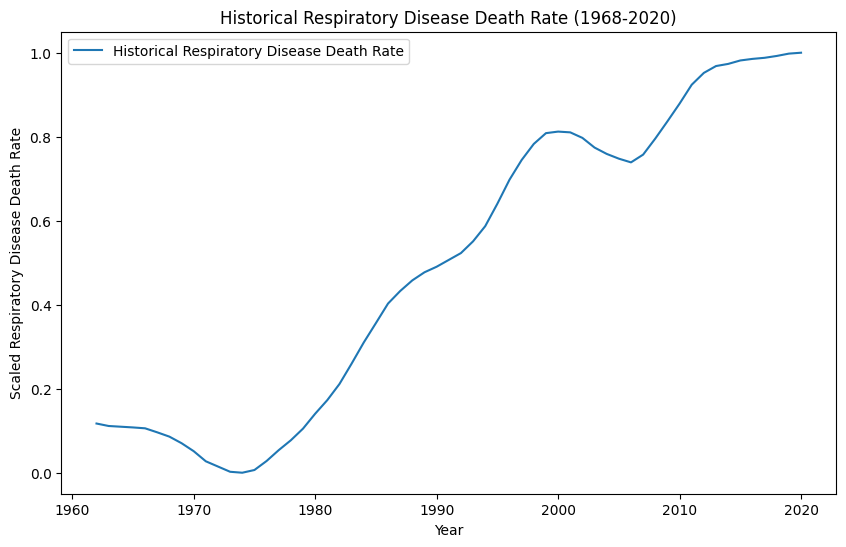

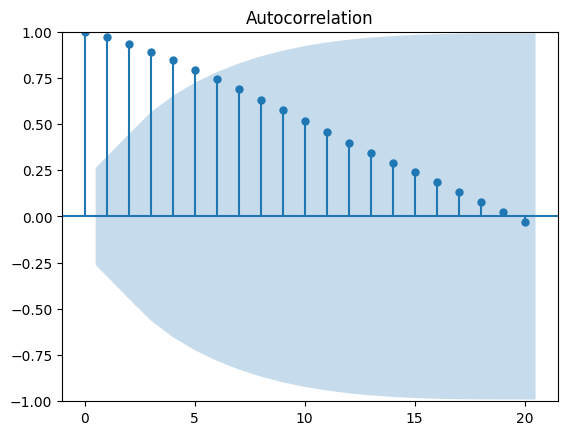

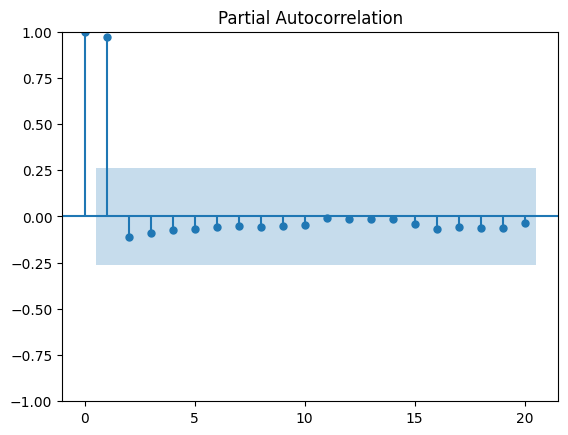

In [18]:
def plot_resp_acf_pacf():
    # create copy to avoid in place modifications 
    df_copy = df.copy()
    df_copy.set_index('Year', inplace=False)  

    # show plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_copy['Year'], df_copy['ScaledCrudeRate'], label='Historical Respiratory Disease Death Rate')
    plt.title('Historical Respiratory Disease Death Rate (1968-2020)')
    plt.xlabel('Year')
    plt.ylabel('Scaled Respiratory Disease Death Rate')
    plt.legend()
    plt.show()

    # check ACF and PACF plots to determine ARIMA order
    plot_acf(df_copy['ScaledCrudeRate'], lags=20)
    plot_pacf(df_copy['ScaledCrudeRate'], lags=20)
    plt.show()

plot_resp_acf_pacf()

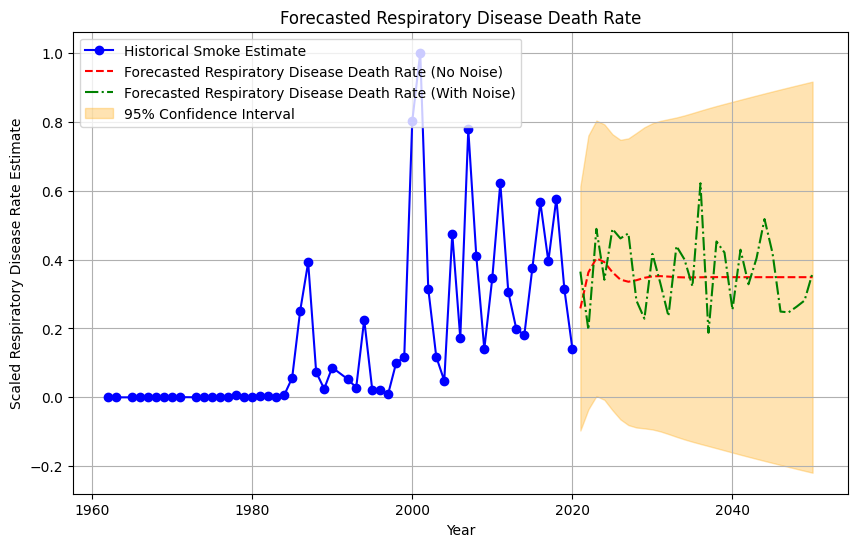

In [21]:
def plot_arimax():
    df_copy = df.copy()
    df_copy.set_index('Year', inplace=False)  
    # fit ARIMA model to smoke estimate 
    model_smoke = ARIMA(df_copy['ScaledEstimate'], order=(2, 1, 2))
    model_smoke_fit = model_smoke.fit()

    # forecast the next 30 years (2021-2050) 
    forecast_years = 30

    # calculate forecast values and confidence intervals
    forecast_result = model_smoke_fit.get_forecast(steps=forecast_years, alpha=0.05)

    # extract forecast and confidence intervals
    forecast_smoke = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()  # Returns the confidence interval for each forecasted point

    # add random noise to the forecast 
    noise_std = 0.1
    random_noise = np.random.normal(0, noise_std, forecast_years)

    # original forecast (no random noise)
    forecast_smoke_with_noise = forecast_smoke + random_noise

    # create forecasted years list
    forecast_years_range = list(range(2021, 2021 + forecast_years))

    # plot data with noise 
    plt.figure(figsize=(10, 6))
    plt.plot(df_copy['Year'], df_copy['ScaledEstimate'], label='Historical Smoke Estimate', color='blue', marker='o')
    plt.plot(forecast_years_range, forecast_smoke, label='Forecasted Respiratory Disease Death Rate (No Noise)', color='red', linestyle='--')
    plt.plot(forecast_years_range, forecast_smoke_with_noise, label='Forecasted Respiratory Disease Death Rate (With Noise)', color='green', linestyle='-.')

    # plot confidence intervals
    plt.fill_between(forecast_years_range, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3, label='95% Confidence Interval')

    # show plot 
    plt.title('Forecasted Respiratory Disease Death Rate')
    plt.xlabel('Year')
    plt.ylabel('Scaled Respiratory Disease Rate Estimate')
    plt.legend(loc = 'upper left')
    plt.grid()
    plt.show()

plot_arimax()